# VLB SAOS: NLSQ → NUTS

**Epstein metal-organic coordination network — storage and loss moduli**

## Learning Objectives

- Fit SAOS (G′, G″) to extract G₀ and k_d
- Understand why SAOS is the best protocol for VLB parameter identification
- Construct posterior predictive for both moduli
- Use crossover frequency as a direct read of k_d

## Data Source

Epstein et al. metal-organic coordination network SAOS data.
This system shows clear Maxwell (single-mode) behavior.

## Estimated Runtime

- Fast demo (1 chain): ~1 min
- Full run (4 chains): ~3 min

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings('ignore', category=FutureWarning)

# Tutorial utilities
import sys

sys.path.insert(0, str(Path('..').resolve()))
from utils.vlb_tutorial_utils import (
    get_bayesian_config,
    get_output_dir,
    load_epstein_saos,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
)

print(f"JAX version: {jax.__version__}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3


## 2. Load Experimental Data

Data points: 19
Frequency range: 0.10 - 99 rad/s
G' range: 8.3 - 2930 Pa


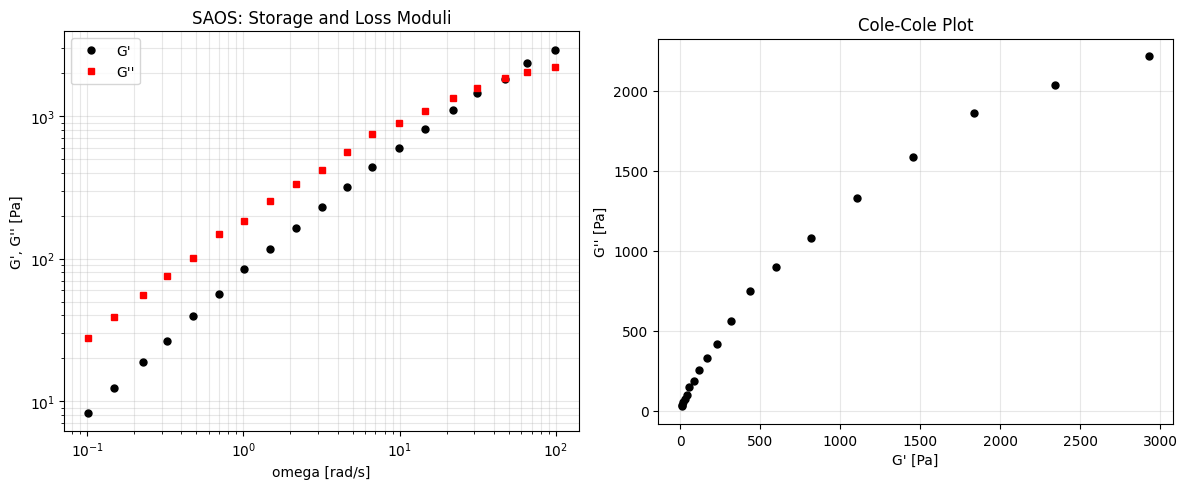

In [3]:
omega, G_prime, G_double_prime = load_epstein_saos()
G_star = G_prime + 1j * G_double_prime

print(f'Data points: {len(omega)}')
print(f'Frequency range: {omega.min():.2f} - {omega.max():.0f} rad/s')
print(f"G' range: {G_prime.min():.1f} - {G_prime.max():.0f} Pa")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.loglog(omega, G_prime, 'ko', markersize=5, label="G'")
ax1.loglog(omega, G_double_prime, 'rs', markersize=5, label="G''")
ax1.set_xlabel('omega [rad/s]')
ax1.set_ylabel("G', G'' [Pa]")
ax1.set_title('SAOS: Storage and Loss Moduli')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Cole-Cole
ax2.plot(G_prime, G_double_prime, 'ko', markersize=5)
ax2.set_xlabel("G' [Pa]")
ax2.set_ylabel("G'' [Pa]")
ax2.set_title('Cole-Cole Plot')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 3. VLB Forward Model

Maxwell SAOS moduli:

$$G'(\omega) = G_0 \frac{\omega^2 t_R^2}{1 + \omega^2 t_R^2}, \quad G''(\omega) = G_0 \frac{\omega t_R}{1 + \omega^2 t_R^2}$$

with $t_R = 1/k_d$.

**Why SAOS is best for VLB:**
- **Crossover** $G'(\omega_c) = G''(\omega_c)$ at $\omega_c = k_d$ → identifies $k_d$ directly
- **Plateau** $G'(\omega \gg k_d) \to G_0$ → identifies $G_0$ directly
- Both parameters are uniquely determined (unlike flow curve)

## 4. Step 1: NLSQ Point Estimation

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.802085s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.5399 | elapsed=0.802s | final_gradient_norm=20.5773


NLSQ fit time: 1.10 s
G0  = 2200.8 Pa
k_d = 11.7607 1/s (= crossover freq)
t_R = 0.0850 s
eta_0 = 187.1 Pa*s
R-squared (|G*|) = 0.840341


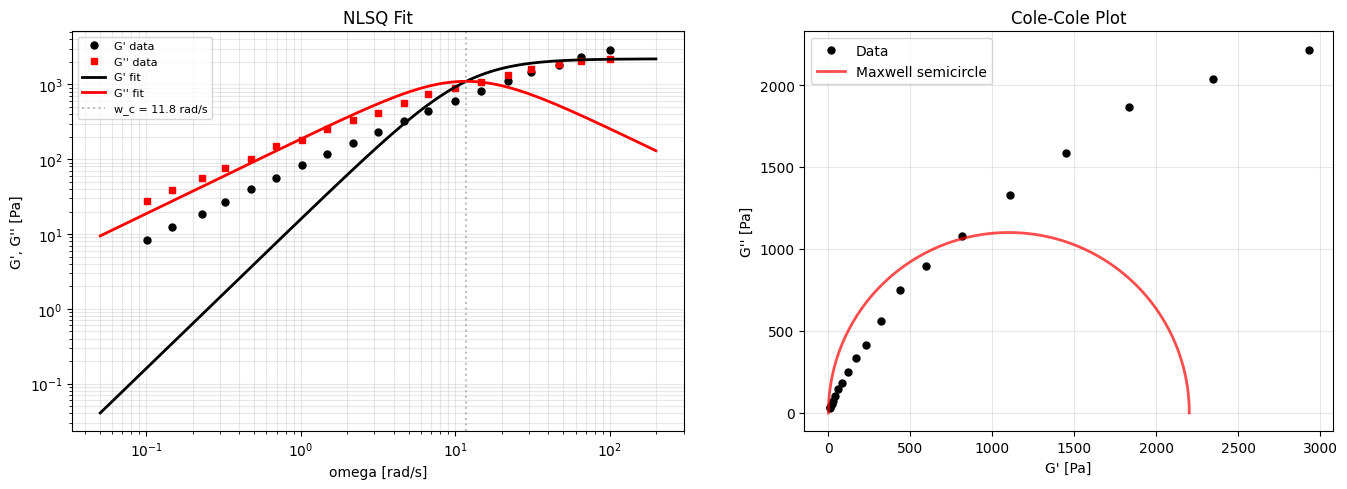

In [4]:
model = VLBLocal()

t0 = time.time()
model.fit(omega, G_star, test_mode='oscillation')
t_nlsq = time.time() - t0

print(f'NLSQ fit time: {t_nlsq:.2f} s')
print(f'G0  = {model.G0:.1f} Pa')
print(f'k_d = {model.k_d:.4f} 1/s (= crossover freq)')
print(f't_R = {1/model.k_d:.4f} s')
print(f'eta_0 = {model.G0 / model.k_d:.1f} Pa*s')

# Fit quality
omega_fine = np.logspace(
    np.log10(omega.min()) - 0.3,
    np.log10(omega.max()) + 0.3, 200
)
Gp_pred, Gdp_pred = model.predict_saos(omega_fine)
Gp_data_pred, Gdp_data_pred = model.predict_saos(omega)

# R-squared on |G*|
Gs_pred = np.sqrt(np.array(Gp_data_pred)**2 + np.array(Gdp_data_pred)**2)
Gs_data = np.abs(G_star)
r2 = 1 - np.sum((Gs_data - Gs_pred)**2) / np.sum((Gs_data - np.mean(Gs_data))**2)
print(f'R-squared (|G*|) = {r2:.6f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(omega, G_prime, 'ko', markersize=5, label="G' data")
ax1.loglog(omega, G_double_prime, 'rs', markersize=5, label="G'' data")
ax1.loglog(omega_fine, Gp_pred, 'k-', lw=2, label="G' fit")
ax1.loglog(omega_fine, Gdp_pred, 'r-', lw=2, label="G'' fit")
ax1.axvline(model.k_d, color='gray', ls=':', alpha=0.5,
            label=f'w_c = {model.k_d:.1f} rad/s')
ax1.set_xlabel('omega [rad/s]')
ax1.set_ylabel("G', G'' [Pa]")
ax1.set_title('NLSQ Fit')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which='both')

# Cole-Cole with Maxwell semicircle
theta = np.linspace(0, np.pi, 100)
cc_Gp = model.G0 / 2 * (1 + np.cos(theta))
cc_Gdp = model.G0 / 2 * np.sin(theta)
ax2.plot(G_prime, G_double_prime, 'ko', markersize=5, label='Data')
ax2.plot(cc_Gp, cc_Gdp, 'r-', lw=2, alpha=0.7, label='Maxwell semicircle')
ax2.set_xlabel("G' [Pa]")
ax2.set_ylabel("G'' [Pa]")
ax2.set_title('Cole-Cole Plot')
ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Step 2: Bayesian Inference (NUTS)

In [5]:
config = get_bayesian_config()
initial_values = {'G0': float(model.G0), 'k_d': float(model.k_d)}
print(f'Config: {config}')
print(f'Warm-start: {initial_values}')

t0 = time.time()
result = model.fit_bayesian(
    omega, G_star, test_mode='oscillation',
    initial_values=initial_values,
    seed=42,
    **config,
)
t_bayes = time.time() - t0
print(f'\nBayesian inference time: {t_bayes:.1f} s')

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}
Warm-start: {'G0': 2200.808130188857, 'k_d': 11.760658583529494}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<01:25,  1.74it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

sample: 100%|██████████| 150/150 [00:00<00:00, 245.92it/s, 31 steps of size 4.13e-02. acc. prob=0.95]


Bayesian inference time: 2.6 s


## 5. Convergence Diagnostics

In [6]:
param_names = ["G0", "k_d"]
converged = print_convergence(result, param_names)

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
        G0    1.0461        44 *
       k_d    1.0118        43 *

Divergences: 0
Convergence: CHECK REQUIRED


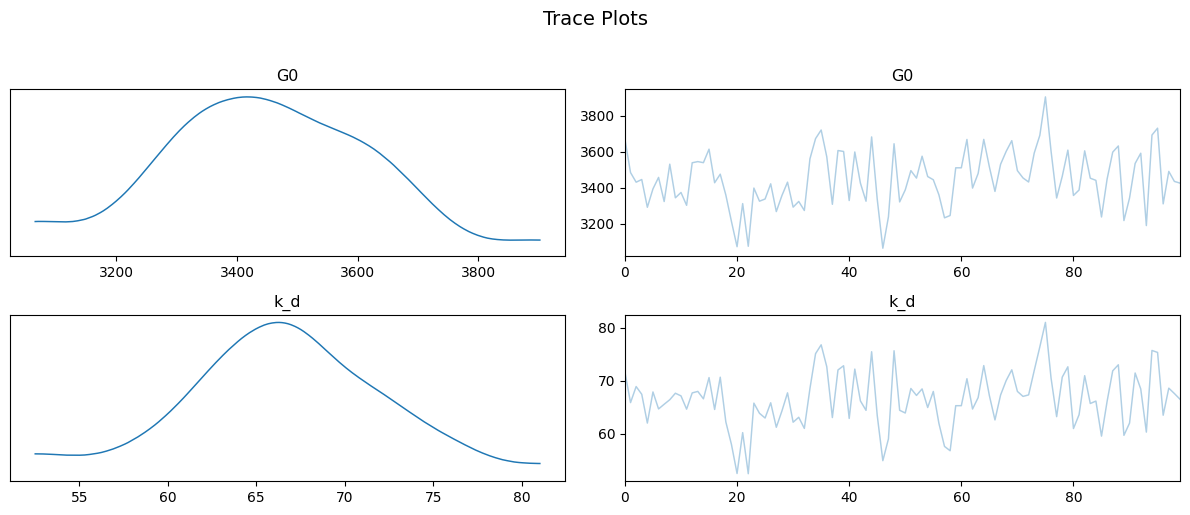

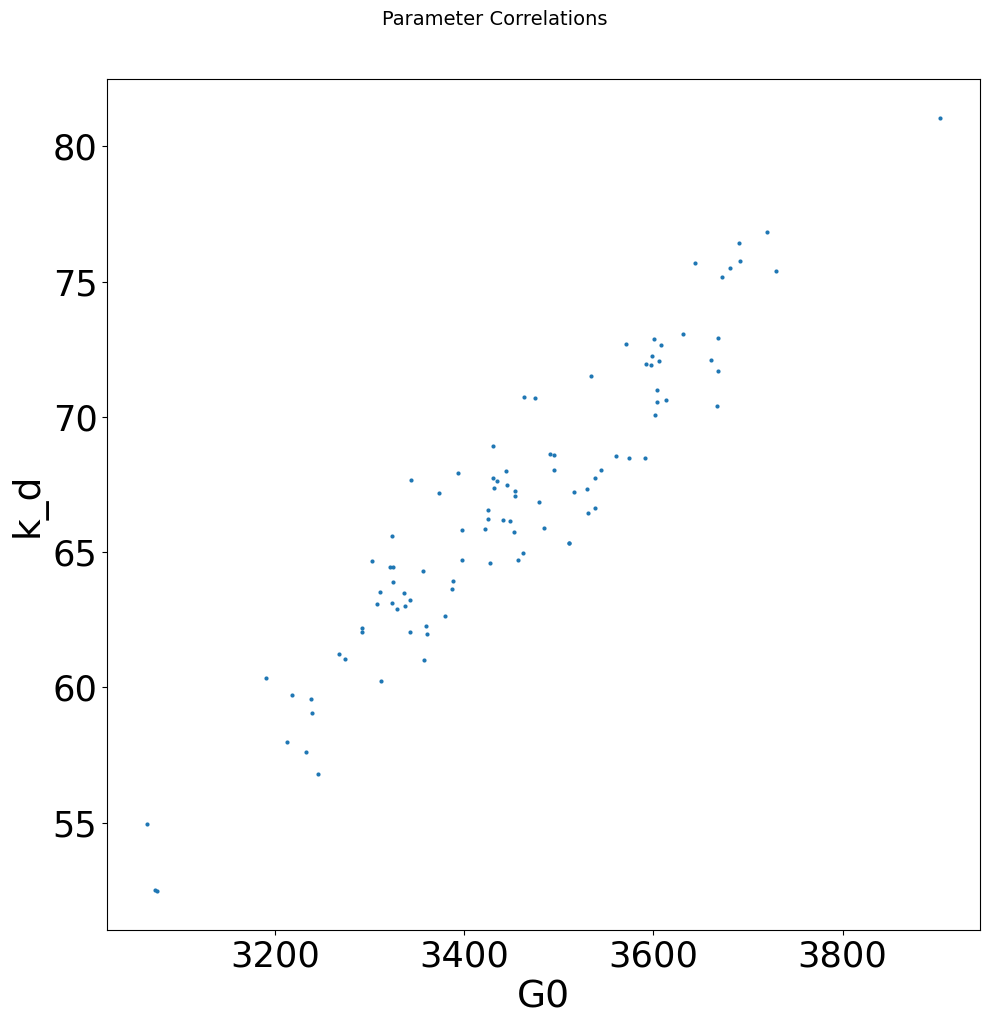

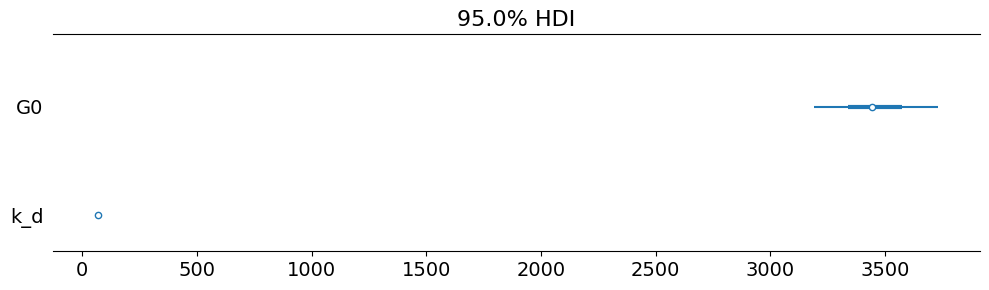

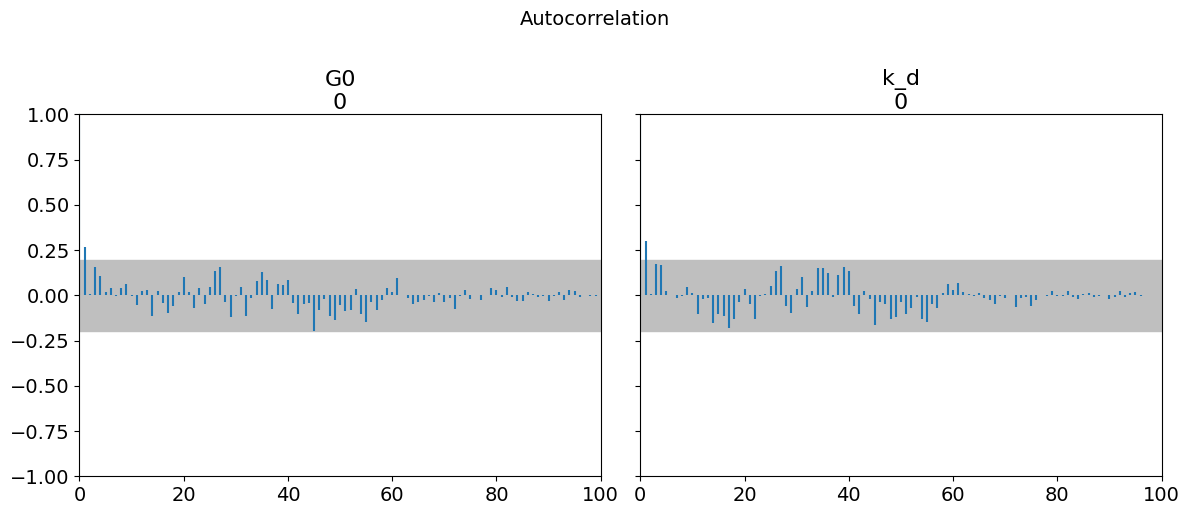

In [7]:
display_arviz_diagnostics(result, param_names, fast_mode=os.environ.get("FAST_MODE", "1") == "1")

## 6. Posterior Summary

In [8]:
posterior = result.posterior_samples
nlsq_vals = {"G0": model.G0, "k_d": model.k_d}
print_parameter_table(["G0", "k_d"], nlsq_vals, posterior)

Parameter Comparison
   Param        NLSQ  Bayes (median)                95% CI
----------------------------------------------------------
      G0        2201            3445  [3130, 3707]
     k_d       11.76           66.58  [55.83, 76.11]


## 7. Posterior Predictive Check

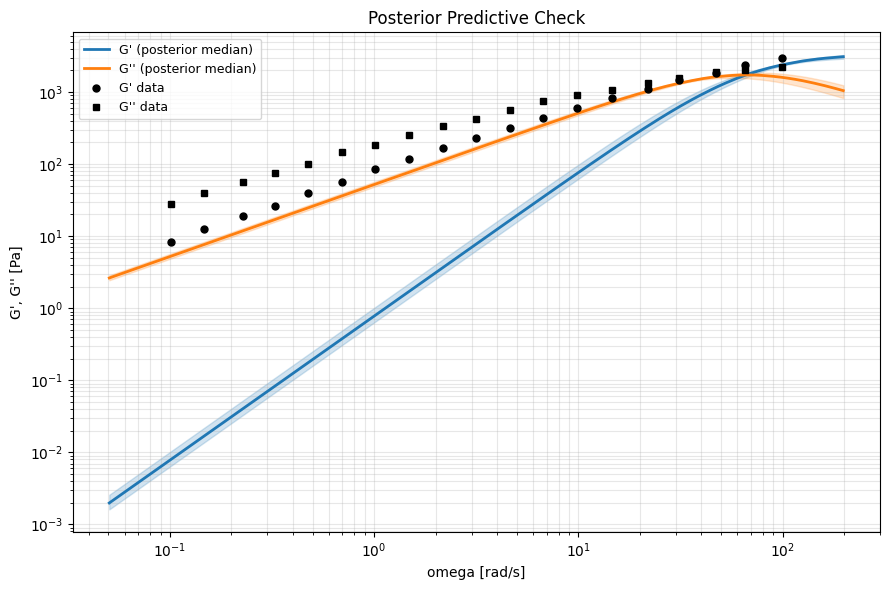

In [9]:
posterior = result.posterior_samples
n_draws = min(200, len(posterior['G0']))

Gp_samples, Gdp_samples = [], []
for i in range(n_draws):
    model.parameters.set_value('G0', float(posterior['G0'][i]))
    model.parameters.set_value('k_d', float(posterior['k_d'][i]))
    Gp_i, Gdp_i = model.predict_saos(omega_fine)
    Gp_samples.append(np.array(Gp_i))
    Gdp_samples.append(np.array(Gdp_i))

Gp_arr = np.array(Gp_samples)
Gdp_arr = np.array(Gdp_samples)

fig, ax = plt.subplots(figsize=(9, 6))

# 95% CI bands
ax.fill_between(omega_fine,
    np.percentile(Gp_arr, 2.5, axis=0),
    np.percentile(Gp_arr, 97.5, axis=0),
    alpha=0.2, color='C0')
ax.fill_between(omega_fine,
    np.percentile(Gdp_arr, 2.5, axis=0),
    np.percentile(Gdp_arr, 97.5, axis=0),
    alpha=0.2, color='C1')

# Medians
ax.loglog(omega_fine, np.median(Gp_arr, axis=0),
          'C0-', lw=2, label="G' (posterior median)")
ax.loglog(omega_fine, np.median(Gdp_arr, axis=0),
          'C1-', lw=2, label="G'' (posterior median)")

# Data
ax.loglog(omega, G_prime, 'ko', markersize=5, label="G' data")
ax.loglog(omega, G_double_prime, 'ks', markersize=5, label="G'' data")

ax.set_xlabel('omega [rad/s]')
ax.set_ylabel("G', G'' [Pa]")
ax.set_title('Posterior Predictive Check')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

## 7b. Derived Quantities with Uncertainty

In [10]:
G0_s = np.array(posterior['G0'])
kd_s = np.array(posterior['k_d'])
tR_s = 1.0 / kd_s
eta_s = G0_s / kd_s

print('Derived Quantities (posterior)')
print('=' * 55)
for name, samples in [
    ('t_R [s]', tR_s),
    ('eta_0 [Pa*s]', eta_s),
]:
    med = np.median(samples)
    lo, hi = np.percentile(samples, [2.5, 97.5])
    print(f'  {name:15s}: {med:.4g} [{lo:.4g}, {hi:.4g}]')

Derived Quantities (posterior)
  t_R [s]        : 0.01502 [0.01314, 0.01792]
  eta_0 [Pa*s]   : 52.01 [48.35, 56.64]


## 8. Save Results

In [11]:
output_dir = get_output_dir("saos")
save_results(output_dir, model, result, ["G0", "k_d"], None)
print("Done.")

Saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/vlb/saos/
Done.


## Key Takeaways

1. **SAOS is the gold standard** for VLB parameter identification
2. **Crossover frequency** directly reads k_d
3. **High-frequency plateau** reads G₀
4. **Cole-Cole semicircle** confirms single Maxwell mode
5. **Tight posteriors** reflect strong parameter identifiability

## Next

- **Notebook 16**: LAOS NLSQ → NUTS